In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision.datasets import ImageFolder
from torchinfo import summary
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import wandb 
from PIL import Image
import glob
import json
import shutil
import random
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
# import tensorflow as tf

torch.manual_seed(11)
np.random.seed(11)
random.seed(11)
# plt.style.use('ggplot')

In [2]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Z_DIM = 100
IMG_CHANNELS = 3
FEATURES_G = 64
FEATURES_D = 64
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
LEARNING_RATE_G = 2e-4
LEARNING_RATE_D = 1e-4
NUM_EPOCHS = 100
BETAS = (0.0, 0.9)
LAMBDA_GP = 10
N_CRITIC = 5
SAVE_INTERVAL = 50

class CustomDataset(Dataset):
    def __init__(self, noise_dir, image_dir, transform=None):
        self.noise_dir = noise_dir
        self.image_dir = image_dir
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.noise_paths = sorted(glob.glob(os.path.join(noise_dir, "*.npy")))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index, flag=False):
        noise = np.load(self.noise_paths[index])
        noise = torch.tensor(noise, dtype=torch.float32).view(Z_DIM, 1, 1)
        image = Image.open(self.image_paths[index])
        if flag:
            print(f'Image:{(np.array(image).shape)}')
            print(f'noise:{noise.shape}')
            plt.imshow(np.array(image))
            plt.show()
        if self.transform is not None:
            image = self.transform(image)
            
        return noise, image

In [3]:
noise_dir = "../Submission/NEW_QUery_generated_dataset/noise_vectors"
image_dir = "../Submission/NEW_QUery_generated_dataset/images"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_ds = CustomDataset(noise_dir=noise_dir, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

The Generated images are 4-Channel images, so we I am considering only the first 3 channels for the surrogate model. \
Differentiating between 4-Channel and 3-Channel images is important for the surrogate model to generate realistic images. \
The changes in both the 4CH and 3CH images can be seen in the image below.

Image:(64, 64, 4)
noise:torch.Size([100, 1, 1])


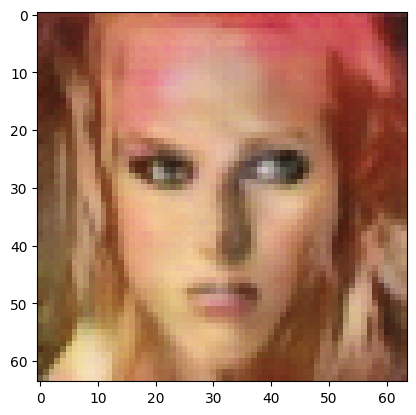

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noise:torch.Size([100, 1, 1])
Image:torch.Size([3, 64, 64])


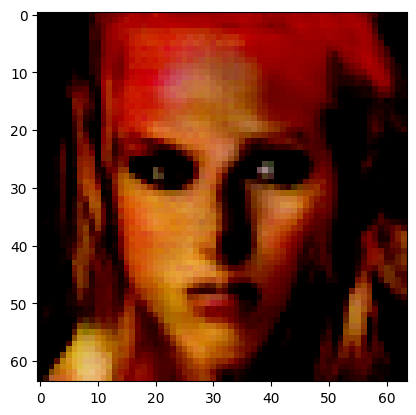

In [48]:
noise, img = train_ds.__getitem__(index=random.randint(0, len(train_ds)-1), flag=True)
print(f'Noise:{noise.shape}')
print(f'Image:{img.shape}')
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.show()

### Generator

In [7]:
class SelfAttention(nn.Module):
    """ Self-Attention layer to capture global dependencies """
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        q = self.query(x).view(B, -1, H * W)  # (B, C/8, H*W)
        k = self.key(x).view(B, -1, H * W).permute(0, 2, 1)  # (B, H*W, C/8)
        v = self.value(x).view(B, -1, H * W)  # (B, C, H*W)

        attention = torch.bmm(q, k) / (H * W)  # Attention map
        attention = torch.nn.functional.softmax(attention, dim=-1)

        out = torch.bmm(v, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(B, C, H, W)
        return self.gamma * out + x  # Skip connection

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            # N x f_g*16 x 4 x 4
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            # N x f_g*8 x 8 x 8
            SelfAttention(features_g * 8), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1), 
            # N x f_g*4 x 16 x 16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            # N x f_g*2 x 32 x 32
            nn.ConvTranspose2d(features_g * 2, img_channels, 4, 2, 1),  
            # N x img_channels x 64 x 64
            nn.Tanh()
        )

    def _block(self, in_ch, out_ch, kernel_size, stride, padding):
        return nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)), 
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True) 
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1).unsqueeze(-1)
        return self.gen(x)

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.BatchNorm2d, nn.ConvTranspose2d)):
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            else:
                nn.init.kaiming_normal_(m.weight) 


In [8]:
gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G).to(DEVICE)
init_weights(gen)
summary(gen, (1, Z_DIM, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Sequential: 2-1                   [1, 1024, 4, 4]           --
│    │    └─ConvTranspose2d: 3-1         [1, 1024, 4, 4]           1,638,400
│    │    └─BatchNorm2d: 3-2             [1, 1024, 4, 4]           2,048
│    │    └─LeakyReLU: 3-3               [1, 1024, 4, 4]           --
│    └─Sequential: 2-2                   [1, 512, 8, 8]            --
│    │    └─ConvTranspose2d: 3-4         [1, 512, 8, 8]            8,388,608
│    │    └─BatchNorm2d: 3-5             [1, 512, 8, 8]            1,024
│    │    └─LeakyReLU: 3-6               [1, 512, 8, 8]            --
│    └─SelfAttention: 2-3                [1, 512, 8, 8]            1
│    │    └─Conv2d: 3-7                  [1, 64, 8, 8]             32,832
│    │    └─Conv2d: 3-8                  [1, 64, 8, 8]        

### Purely Reconstruction loss based trained Reference Generator (Shadow Model)


Training Generator(RCL only):   1%|          | 1/120 [00:01<03:31,  1.77s/it]

Epoch: 0 | Loss: 0.1325


Training Generator(RCL only):   2%|▏         | 2/120 [00:03<03:10,  1.62s/it]

Epoch: 1 | Loss: 0.0971


Training Generator(RCL only):   2%|▎         | 3/120 [00:04<03:02,  1.56s/it]

Epoch: 2 | Loss: 0.0888


Training Generator(RCL only):   3%|▎         | 4/120 [00:06<02:57,  1.53s/it]

Epoch: 3 | Loss: 0.0865


Training Generator(RCL only):   4%|▍         | 5/120 [00:07<02:53,  1.51s/it]

Epoch: 4 | Loss: 0.0844


Training Generator(RCL only):   5%|▌         | 6/120 [00:09<02:52,  1.51s/it]

Epoch: 5 | Loss: 0.0832


Training Generator(RCL only):   6%|▌         | 7/120 [00:10<02:49,  1.50s/it]

Epoch: 6 | Loss: 0.0827


Training Generator(RCL only):   7%|▋         | 8/120 [00:12<02:46,  1.49s/it]

Epoch: 7 | Loss: 0.0824


Training Generator(RCL only):   8%|▊         | 9/120 [00:13<02:44,  1.48s/it]

Epoch: 8 | Loss: 0.0810


Training Generator(RCL only):   8%|▊         | 10/120 [00:15<02:42,  1.48s/it]

Epoch: 9 | Loss: 0.0795


Training Generator(RCL only):   9%|▉         | 11/120 [00:16<02:42,  1.49s/it]

Epoch: 10 | Loss: 0.0790


Training Generator(RCL only):  10%|█         | 12/120 [00:18<02:40,  1.48s/it]

Epoch: 11 | Loss: 0.0788


Training Generator(RCL only):  11%|█         | 13/120 [00:19<02:39,  1.49s/it]

Epoch: 12 | Loss: 0.0762


Training Generator(RCL only):  12%|█▏        | 14/120 [00:21<02:38,  1.50s/it]

Epoch: 13 | Loss: 0.0746


Training Generator(RCL only):  12%|█▎        | 15/120 [00:22<02:36,  1.49s/it]

Epoch: 14 | Loss: 0.0733


Training Generator(RCL only):  13%|█▎        | 16/120 [00:24<02:34,  1.49s/it]

Epoch: 15 | Loss: 0.0701


Training Generator(RCL only):  14%|█▍        | 17/120 [00:25<02:33,  1.49s/it]

Epoch: 16 | Loss: 0.0670


Training Generator(RCL only):  15%|█▌        | 18/120 [00:27<02:32,  1.50s/it]

Epoch: 17 | Loss: 0.0651


Training Generator(RCL only):  16%|█▌        | 19/120 [00:28<02:31,  1.50s/it]

Epoch: 18 | Loss: 0.0628


Training Generator(RCL only):  17%|█▋        | 20/120 [00:30<02:29,  1.50s/it]

Epoch: 19 | Loss: 0.0611


Training Generator(RCL only):  18%|█▊        | 21/120 [00:31<02:31,  1.53s/it]

Epoch: 20 | Loss: 0.0617


Training Generator(RCL only):  18%|█▊        | 22/120 [00:33<02:29,  1.53s/it]

Epoch: 21 | Loss: 0.0608


Training Generator(RCL only):  19%|█▉        | 23/120 [00:34<02:26,  1.51s/it]

Epoch: 22 | Loss: 0.0590


Training Generator(RCL only):  20%|██        | 24/120 [00:36<02:25,  1.51s/it]

Epoch: 23 | Loss: 0.0583


Training Generator(RCL only):  21%|██        | 25/120 [00:37<02:22,  1.50s/it]

Epoch: 24 | Loss: 0.0569


Training Generator(RCL only):  22%|██▏       | 26/120 [00:39<02:21,  1.50s/it]

Epoch: 25 | Loss: 0.0559


Training Generator(RCL only):  22%|██▎       | 27/120 [00:40<02:19,  1.50s/it]

Epoch: 26 | Loss: 0.0543


Training Generator(RCL only):  23%|██▎       | 28/120 [00:42<02:17,  1.49s/it]

Epoch: 27 | Loss: 0.0544


Training Generator(RCL only):  24%|██▍       | 29/120 [00:43<02:14,  1.48s/it]

Epoch: 28 | Loss: 0.0536


Training Generator(RCL only):  25%|██▌       | 30/120 [00:45<02:13,  1.48s/it]

Epoch: 29 | Loss: 0.0539


Training Generator(RCL only):  26%|██▌       | 31/120 [00:46<02:11,  1.48s/it]

Epoch: 30 | Loss: 0.0535


Training Generator(RCL only):  27%|██▋       | 32/120 [00:48<02:10,  1.49s/it]

Epoch: 31 | Loss: 0.0535


Training Generator(RCL only):  28%|██▊       | 33/120 [00:49<02:09,  1.49s/it]

Epoch: 32 | Loss: 0.0531


Training Generator(RCL only):  28%|██▊       | 34/120 [00:51<02:07,  1.48s/it]

Epoch: 33 | Loss: 0.0527


Training Generator(RCL only):  29%|██▉       | 35/120 [00:52<02:05,  1.48s/it]

Epoch: 34 | Loss: 0.0521


Training Generator(RCL only):  30%|███       | 36/120 [00:53<02:04,  1.48s/it]

Epoch: 35 | Loss: 0.0517


Training Generator(RCL only):  31%|███       | 37/120 [00:55<02:03,  1.49s/it]

Epoch: 36 | Loss: 0.0501


Training Generator(RCL only):  32%|███▏      | 38/120 [00:56<02:02,  1.50s/it]

Epoch: 37 | Loss: 0.0496


Training Generator(RCL only):  32%|███▎      | 39/120 [00:58<02:01,  1.50s/it]

Epoch: 38 | Loss: 0.0500


Training Generator(RCL only):  33%|███▎      | 40/120 [01:00<02:00,  1.51s/it]

Epoch: 39 | Loss: 0.0507


Training Generator(RCL only):  34%|███▍      | 41/120 [01:01<02:01,  1.54s/it]

Epoch: 40 | Loss: 0.0499


Training Generator(RCL only):  35%|███▌      | 42/120 [01:03<02:01,  1.56s/it]

Epoch: 41 | Loss: 0.0493


Training Generator(RCL only):  36%|███▌      | 43/120 [01:04<01:59,  1.55s/it]

Epoch: 42 | Loss: 0.0495


Training Generator(RCL only):  37%|███▋      | 44/120 [01:06<01:57,  1.55s/it]

Epoch: 43 | Loss: 0.0485


Training Generator(RCL only):  38%|███▊      | 45/120 [01:07<01:55,  1.54s/it]

Epoch: 44 | Loss: 0.0490


Training Generator(RCL only):  38%|███▊      | 46/120 [01:09<01:53,  1.54s/it]

Epoch: 45 | Loss: 0.0491


Training Generator(RCL only):  39%|███▉      | 47/120 [01:10<01:52,  1.54s/it]

Epoch: 46 | Loss: 0.0485


Training Generator(RCL only):  40%|████      | 48/120 [01:12<01:50,  1.53s/it]

Epoch: 47 | Loss: 0.0486


Training Generator(RCL only):  41%|████      | 49/120 [01:13<01:49,  1.54s/it]

Epoch: 48 | Loss: 0.0482


Training Generator(RCL only):  42%|████▏     | 50/120 [01:15<01:48,  1.55s/it]

Epoch: 49 | Loss: 0.0478


Training Generator(RCL only):  42%|████▎     | 51/120 [01:17<01:49,  1.59s/it]

Epoch: 50 | Loss: 0.0479


Training Generator(RCL only):  43%|████▎     | 52/120 [01:18<01:47,  1.58s/it]

Epoch: 51 | Loss: 0.0469


Training Generator(RCL only):  44%|████▍     | 53/120 [01:20<01:46,  1.58s/it]

Epoch: 52 | Loss: 0.0465


Training Generator(RCL only):  45%|████▌     | 54/120 [01:21<01:44,  1.58s/it]

Epoch: 53 | Loss: 0.0460


Training Generator(RCL only):  46%|████▌     | 55/120 [01:23<01:44,  1.61s/it]

Epoch: 54 | Loss: 0.0461


Training Generator(RCL only):  47%|████▋     | 56/120 [01:25<01:44,  1.64s/it]

Epoch: 55 | Loss: 0.0464


Training Generator(RCL only):  48%|████▊     | 57/120 [01:26<01:42,  1.63s/it]

Epoch: 56 | Loss: 0.0456


Training Generator(RCL only):  48%|████▊     | 58/120 [01:28<01:40,  1.62s/it]

Epoch: 57 | Loss: 0.0453


Training Generator(RCL only):  49%|████▉     | 59/120 [01:30<01:38,  1.61s/it]

Epoch: 58 | Loss: 0.0461


Training Generator(RCL only):  50%|█████     | 60/120 [01:31<01:36,  1.60s/it]

Epoch: 59 | Loss: 0.0454


Training Generator(RCL only):  51%|█████     | 61/120 [01:33<01:35,  1.62s/it]

Epoch: 60 | Loss: 0.0461


Training Generator(RCL only):  52%|█████▏    | 62/120 [01:34<01:33,  1.61s/it]

Epoch: 61 | Loss: 0.0453


Training Generator(RCL only):  52%|█████▎    | 63/120 [01:36<01:31,  1.60s/it]

Epoch: 62 | Loss: 0.0454


Training Generator(RCL only):  53%|█████▎    | 64/120 [01:38<01:28,  1.58s/it]

Epoch: 63 | Loss: 0.0454


Training Generator(RCL only):  54%|█████▍    | 65/120 [01:39<01:27,  1.59s/it]

Epoch: 64 | Loss: 0.0452


Training Generator(RCL only):  55%|█████▌    | 66/120 [01:41<01:26,  1.61s/it]

Epoch: 65 | Loss: 0.0448


Training Generator(RCL only):  56%|█████▌    | 67/120 [01:42<01:25,  1.61s/it]

Epoch: 66 | Loss: 0.0447


Training Generator(RCL only):  57%|█████▋    | 68/120 [01:44<01:23,  1.60s/it]

Epoch: 67 | Loss: 0.0443


Training Generator(RCL only):  57%|█████▊    | 69/120 [01:46<01:21,  1.61s/it]

Epoch: 68 | Loss: 0.0446


Training Generator(RCL only):  58%|█████▊    | 70/120 [01:47<01:20,  1.61s/it]

Epoch: 69 | Loss: 0.0445


Training Generator(RCL only):  59%|█████▉    | 71/120 [01:49<01:18,  1.61s/it]

Epoch: 70 | Loss: 0.0451


Training Generator(RCL only):  60%|██████    | 72/120 [01:50<01:17,  1.61s/it]

Epoch: 71 | Loss: 0.0445


Training Generator(RCL only):  61%|██████    | 73/120 [01:52<01:15,  1.62s/it]

Epoch: 72 | Loss: 0.0440


Training Generator(RCL only):  62%|██████▏   | 74/120 [01:54<01:14,  1.62s/it]

Epoch: 73 | Loss: 0.0424


Training Generator(RCL only):  62%|██████▎   | 75/120 [01:55<01:12,  1.61s/it]

Epoch: 74 | Loss: 0.0421


Training Generator(RCL only):  63%|██████▎   | 76/120 [01:57<01:10,  1.59s/it]

Epoch: 75 | Loss: 0.0431


Training Generator(RCL only):  64%|██████▍   | 77/120 [01:58<01:08,  1.59s/it]

Epoch: 76 | Loss: 0.0427


Training Generator(RCL only):  65%|██████▌   | 78/120 [02:00<01:07,  1.61s/it]

Epoch: 77 | Loss: 0.0421


Training Generator(RCL only):  66%|██████▌   | 79/120 [02:02<01:05,  1.59s/it]

Epoch: 78 | Loss: 0.0421


Training Generator(RCL only):  67%|██████▋   | 80/120 [02:03<01:04,  1.60s/it]

Epoch: 79 | Loss: 0.0419


Training Generator(RCL only):  68%|██████▊   | 81/120 [02:05<01:03,  1.62s/it]

Epoch: 80 | Loss: 0.0414


Training Generator(RCL only):  68%|██████▊   | 82/120 [02:07<01:01,  1.62s/it]

Epoch: 81 | Loss: 0.0413


Training Generator(RCL only):  69%|██████▉   | 83/120 [02:08<00:59,  1.60s/it]

Epoch: 82 | Loss: 0.0408


Training Generator(RCL only):  70%|███████   | 84/120 [02:10<00:57,  1.59s/it]

Epoch: 83 | Loss: 0.0397


Training Generator(RCL only):  71%|███████   | 85/120 [02:11<00:55,  1.58s/it]

Epoch: 84 | Loss: 0.0394


Training Generator(RCL only):  72%|███████▏  | 86/120 [02:13<00:53,  1.56s/it]

Epoch: 85 | Loss: 0.0389


Training Generator(RCL only):  72%|███████▎  | 87/120 [02:14<00:51,  1.56s/it]

Epoch: 86 | Loss: 0.0382


Training Generator(RCL only):  73%|███████▎  | 88/120 [02:16<00:49,  1.56s/it]

Epoch: 87 | Loss: 0.0388


Training Generator(RCL only):  74%|███████▍  | 89/120 [02:17<00:48,  1.55s/it]

Epoch: 88 | Loss: 0.0381


Training Generator(RCL only):  75%|███████▌  | 90/120 [02:19<00:46,  1.54s/it]

Epoch: 89 | Loss: 0.0379


Training Generator(RCL only):  76%|███████▌  | 91/120 [02:20<00:44,  1.54s/it]

Epoch: 90 | Loss: 0.0396


Training Generator(RCL only):  77%|███████▋  | 92/120 [02:22<00:43,  1.54s/it]

Epoch: 91 | Loss: 0.0404


Training Generator(RCL only):  78%|███████▊  | 93/120 [02:24<00:41,  1.54s/it]

Epoch: 92 | Loss: 0.0390


Training Generator(RCL only):  78%|███████▊  | 94/120 [02:25<00:39,  1.54s/it]

Epoch: 93 | Loss: 0.0386


Training Generator(RCL only):  79%|███████▉  | 95/120 [02:27<00:38,  1.54s/it]

Epoch: 94 | Loss: 0.0389


Training Generator(RCL only):  80%|████████  | 96/120 [02:28<00:36,  1.54s/it]

Epoch: 95 | Loss: 0.0386


Training Generator(RCL only):  81%|████████  | 97/120 [02:30<00:35,  1.54s/it]

Epoch: 96 | Loss: 0.0383


Training Generator(RCL only):  82%|████████▏ | 98/120 [02:31<00:33,  1.53s/it]

Epoch: 97 | Loss: 0.0386


Training Generator(RCL only):  82%|████████▎ | 99/120 [02:33<00:31,  1.52s/it]

Epoch: 98 | Loss: 0.0381


Training Generator(RCL only):  83%|████████▎ | 100/120 [02:34<00:30,  1.51s/it]

Epoch: 99 | Loss: 0.0379


Training Generator(RCL only):  84%|████████▍ | 101/120 [02:36<00:29,  1.58s/it]

Epoch: 100 | Loss: 0.0378


Training Generator(RCL only):  85%|████████▌ | 102/120 [02:37<00:28,  1.56s/it]

Epoch: 101 | Loss: 0.0375


Training Generator(RCL only):  86%|████████▌ | 103/120 [02:39<00:26,  1.54s/it]

Epoch: 102 | Loss: 0.0383


Training Generator(RCL only):  87%|████████▋ | 104/120 [02:40<00:24,  1.54s/it]

Epoch: 103 | Loss: 0.0381


Training Generator(RCL only):  88%|████████▊ | 105/120 [02:42<00:23,  1.54s/it]

Epoch: 104 | Loss: 0.0372


Training Generator(RCL only):  88%|████████▊ | 106/120 [02:44<00:21,  1.52s/it]

Epoch: 105 | Loss: 0.0374


Training Generator(RCL only):  89%|████████▉ | 107/120 [02:45<00:19,  1.52s/it]

Epoch: 106 | Loss: 0.0376


Training Generator(RCL only):  90%|█████████ | 108/120 [02:47<00:18,  1.51s/it]

Epoch: 107 | Loss: 0.0371


Training Generator(RCL only):  91%|█████████ | 109/120 [02:48<00:16,  1.51s/it]

Epoch: 108 | Loss: 0.0376


Training Generator(RCL only):  92%|█████████▏| 110/120 [02:49<00:14,  1.50s/it]

Epoch: 109 | Loss: 0.0366


Training Generator(RCL only):  92%|█████████▎| 111/120 [02:51<00:13,  1.52s/it]

Epoch: 110 | Loss: 0.0362


Training Generator(RCL only):  93%|█████████▎| 112/120 [02:53<00:12,  1.52s/it]

Epoch: 111 | Loss: 0.0356


Training Generator(RCL only):  94%|█████████▍| 113/120 [02:54<00:10,  1.52s/it]

Epoch: 112 | Loss: 0.0351


Training Generator(RCL only):  95%|█████████▌| 114/120 [02:56<00:09,  1.53s/it]

Epoch: 113 | Loss: 0.0358


Training Generator(RCL only):  96%|█████████▌| 115/120 [02:57<00:07,  1.51s/it]

Epoch: 114 | Loss: 0.0353


Training Generator(RCL only):  97%|█████████▋| 116/120 [02:59<00:06,  1.52s/it]

Epoch: 115 | Loss: 0.0350


Training Generator(RCL only):  98%|█████████▊| 117/120 [03:00<00:04,  1.52s/it]

Epoch: 116 | Loss: 0.0356


Training Generator(RCL only):  98%|█████████▊| 118/120 [03:02<00:03,  1.51s/it]

Epoch: 117 | Loss: 0.0360


Training Generator(RCL only):  99%|█████████▉| 119/120 [03:03<00:01,  1.51s/it]

Epoch: 118 | Loss: 0.0355


Training Generator(RCL only): 100%|██████████| 120/120 [03:05<00:00,  1.55s/it]


Epoch: 119 | Loss: 0.0356


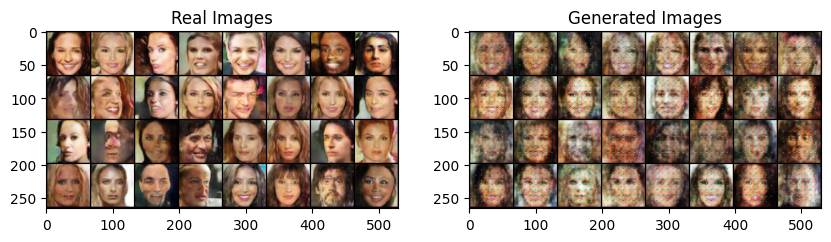

In [10]:
def train_generator_reconstruction_only(gen, dataloader, num_epochs=10, save_dir='../Submission/checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs('../Submission/Real_Ones_RCL', exist_ok=True)
    os.makedirs('../Submission/Gen_Fakes_RCL', exist_ok=True)
    
    gen = gen.to(DEVICE)
    
    optimizer = optim.Adam(gen.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)
    
    loop = tqdm(range(num_epochs), desc='Training Generator(RCL only)', colour='green')
    for epoch in loop:
        total_loss = 0
        
        for batch_idx, (noise, real_images) in enumerate(dataloader):
            noise = noise.to(DEVICE)
            real_images = real_images.to(DEVICE)
            
            fake_images = gen(noise)
            
            loss = criterion(fake_images, real_images)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        
        if epoch % 20 == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                
                real_batch = next(iter(dataloader))[1][:32].to(DEVICE)
                img_grid_real = torchvision.utils.make_grid(real_batch, normalize=True)

                if epoch == num_epochs - 1:    
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
                    plt.title('Real Images')
                    plt.subplot(1, 2, 2)
                    plt.title('Generated Images')
                    plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
                    
                torchvision.utils.save_image(img_grid_real, f'../Submission/RCL_v1_Real_Ones/real_images_{epoch}.png')
                torchvision.utils.save_image(img_grid_fake, f'../Submission/RCL_v1_Gen_Fakes/fake_images_{epoch}.png')
        
        if epoch % SAVE_INTERVAL == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch,
                'gen_state_dict': gen.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{save_dir}/RCL_v1_checkpoint_epoch_{epoch}.pth')
       
        tqdm.write(f'Epoch: {epoch} | Loss: {avg_loss:.4f}')

# train_generator_reconstruction_only(gen, train_loader, num_epochs=120)

### Discriminator (min max) + Reconstruction Loss + WGAN-GP + Attention







In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_dim):
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, features_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )  # 32x32
        
        self.down1 = self._block(features_dim, features_dim * 2, 4, 2, 1)  # 16x16
        self.down2 = self._block(features_dim * 2, features_dim * 4, 4, 2, 1)  # 8x8        
        self.down3 = self._block(features_dim * 4, features_dim * 8, 4, 2, 1)  # 4x4
        
        self.final = nn.Conv2d(features_dim * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)  # 1x1
        self.sigmoid = nn.Sigmoid()
    
    def _block(self, in_ch, out_ch, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.final(x)
        x = self.sigmoid(x)
        return x.view(x.size(0), -1)  
    
disc = Discriminator(IMG_CHANNELS, FEATURES_D).to(DEVICE)
sample_input = torch.randn(1, 3, 64, 64).to(DEVICE)
print(f"Sample input shape: {sample_input.shape}")
output = disc(sample_input)
print(f"Output shape: {output.shape}")

summary(disc, (1, 3, 64, 64))



Sample input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 1])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,072
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
├─Sequential: 1-3                        [1, 256, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
├─Sequential: 1-4                        [1, 512, 4, 4]            --


In [10]:
def plot_losses(g_losses, d_losses, save_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.savefig(f'{save_dir}/loss_plot.png')
    plt.close()


In [11]:

def train_minimax_plus_reconstruction(gen, disc, dataloader, num_epochs=100, save_dir='../Submission/checkpoints', MSE_FACTOR=0.2, SAVE_INTERVAL=30):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs('../Submission/MinMax_BCE_RCL_v2_Real_Ones', exist_ok=True)
    os.makedirs('../Submission/MinMax_BCE_RCL_v2_Gen_Fakes', exist_ok=True)
    
    gen = gen.to(DEVICE)
    disc = disc.to(DEVICE)
    init_weights(gen)
    init_weights(disc)
    
    optimizer_G = optim.Adam(gen.parameters(), lr=LEARNING_RATE_G, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(disc.parameters(), lr=LEARNING_RATE_D, betas=(0.5, 0.999))
    
    # Using BCE Loss
    criterion_BCE = nn.BCELoss()
    criterion_MSE = nn.MSELoss()

    fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)
    
    g_losses = []
    d_losses = []
    
    loop = tqdm(range(num_epochs), desc='Training Minimax + Reconstruction v13', colour='green')
    for epoch in loop:
        total_g_loss = 0
        total_d_loss = 0
        for batch_idx, (noise, real_images) in enumerate(dataloader):
            batch_size = real_images.size(0)
            noise = noise.to(DEVICE)
            real_images = real_images.to(DEVICE)
            
            optimizer_D.zero_grad()
            fake_images = gen(noise)
            
            d_real = disc(real_images)
            d_fake = disc(fake_images.detach()) 
            
            real_labels = torch.ones_like(d_real).to(DEVICE)
            fake_labels = torch.zeros_like(d_fake).to(DEVICE)

            d_loss_real = criterion_BCE(d_real, real_labels)
            d_loss_fake = criterion_BCE(d_fake, fake_labels)
            d_loss = d_loss_real + d_loss_fake
            
            d_loss.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            
            fake_images = gen(noise)
            d_fake = disc(fake_images)

            g_loss = criterion_BCE(d_fake, real_labels)
            
            mse_loss = criterion_MSE(fake_images, real_images)
            g_loss = g_loss + MSE_FACTOR * mse_loss
            
            g_loss.backward()
            optimizer_G.step()
            
            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()
        
        avg_g_loss = total_g_loss / len(dataloader)
        avg_d_loss = total_d_loss / len(dataloader)
        
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
                
        if epoch % 15 == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                
                real_batch = next(iter(dataloader))[1][:32].to(DEVICE)
                img_grid_real = torchvision.utils.make_grid(real_batch, normalize=True)
                if epoch == num_epochs - 1:    
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
                    plt.title('Real Images')
                    plt.subplot(1, 2, 2)
                    plt.title('Generated Images')
                    plt.axis('off')
                    plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
                    
                
                torchvision.utils.save_image(img_grid_real, f'../Submission/MinMax_BCE_RCL_v2_Real_Ones/real_MinMax_v2_{epoch}.png')
                torchvision.utils.save_image(img_grid_fake, f'../Submission/MinMax_BCE_RCL_v2_Gen_Fakes/fake_MinMax_v2_{epoch}.png')
                
        if epoch % SAVE_INTERVAL == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch,
                'gen_state_dict': gen.state_dict(),
                'disc_state_dict': disc.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, f'{save_dir}/MinMax_BCE_v2_ckpt_epoch_{epoch}.pth')
        
        plot_losses(g_losses, d_losses, save_dir)
        
        tqdm.write(f'Epoch: {epoch} | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f}')


Training Minimax + Reconstruction v13:   1%|          | 1/125 [00:02<05:46,  2.79s/it]

Epoch: 0 | G Loss: 2.6052 | D Loss: 3.5005


Training Minimax + Reconstruction v13:   2%|▏         | 2/125 [00:05<05:24,  2.64s/it]

Epoch: 1 | G Loss: 5.4888 | D Loss: 0.4946


Training Minimax + Reconstruction v13:   2%|▏         | 3/125 [00:07<05:17,  2.60s/it]

Epoch: 2 | G Loss: 5.9585 | D Loss: 0.2771


Training Minimax + Reconstruction v13:   3%|▎         | 4/125 [00:10<05:12,  2.59s/it]

Epoch: 3 | G Loss: 6.4835 | D Loss: 0.2385


Training Minimax + Reconstruction v13:   4%|▍         | 5/125 [00:13<05:10,  2.59s/it]

Epoch: 4 | G Loss: 7.0313 | D Loss: 0.2774


Training Minimax + Reconstruction v13:   5%|▍         | 6/125 [00:15<05:06,  2.58s/it]

Epoch: 5 | G Loss: 6.3719 | D Loss: 0.2456


Training Minimax + Reconstruction v13:   6%|▌         | 7/125 [00:18<05:03,  2.58s/it]

Epoch: 6 | G Loss: 6.3621 | D Loss: 0.2040


Training Minimax + Reconstruction v13:   6%|▋         | 8/125 [00:20<05:01,  2.57s/it]

Epoch: 7 | G Loss: 6.1693 | D Loss: 0.1371


Training Minimax + Reconstruction v13:   7%|▋         | 9/125 [00:23<04:59,  2.58s/it]

Epoch: 8 | G Loss: 5.9218 | D Loss: 0.1106


Training Minimax + Reconstruction v13:   8%|▊         | 10/125 [00:25<04:57,  2.58s/it]

Epoch: 9 | G Loss: 6.0698 | D Loss: 0.0934


Training Minimax + Reconstruction v13:   9%|▉         | 11/125 [00:28<04:55,  2.59s/it]

Epoch: 10 | G Loss: 6.0111 | D Loss: 0.0800


Training Minimax + Reconstruction v13:  10%|▉         | 12/125 [00:31<04:54,  2.60s/it]

Epoch: 11 | G Loss: 5.9576 | D Loss: 0.0704


Training Minimax + Reconstruction v13:  10%|█         | 13/125 [00:33<04:51,  2.61s/it]

Epoch: 12 | G Loss: 5.8957 | D Loss: 0.0521


Training Minimax + Reconstruction v13:  11%|█         | 14/125 [00:36<04:49,  2.61s/it]

Epoch: 13 | G Loss: 5.8816 | D Loss: 0.0430


Training Minimax + Reconstruction v13:  12%|█▏        | 15/125 [00:38<04:46,  2.61s/it]

Epoch: 14 | G Loss: 5.9132 | D Loss: 0.0404


Training Minimax + Reconstruction v13:  13%|█▎        | 16/125 [00:41<04:48,  2.65s/it]

Epoch: 15 | G Loss: 5.9452 | D Loss: 0.0280


Training Minimax + Reconstruction v13:  14%|█▎        | 17/125 [00:44<04:45,  2.65s/it]

Epoch: 16 | G Loss: 5.9250 | D Loss: 0.0292


Training Minimax + Reconstruction v13:  14%|█▍        | 18/125 [00:47<04:48,  2.69s/it]

Epoch: 17 | G Loss: 5.9584 | D Loss: 0.0234


Training Minimax + Reconstruction v13:  15%|█▌        | 19/125 [00:49<04:43,  2.68s/it]

Epoch: 18 | G Loss: 5.9748 | D Loss: 0.0276


Training Minimax + Reconstruction v13:  16%|█▌        | 20/125 [00:52<04:40,  2.67s/it]

Epoch: 19 | G Loss: 5.9958 | D Loss: 0.0233


Training Minimax + Reconstruction v13:  17%|█▋        | 21/125 [00:55<04:36,  2.66s/it]

Epoch: 20 | G Loss: 6.0077 | D Loss: 0.0259


Training Minimax + Reconstruction v13:  18%|█▊        | 22/125 [00:57<04:33,  2.66s/it]

Epoch: 21 | G Loss: 6.0763 | D Loss: 0.0223


Training Minimax + Reconstruction v13:  18%|█▊        | 23/125 [01:00<04:30,  2.65s/it]

Epoch: 22 | G Loss: 6.1223 | D Loss: 0.0238


Training Minimax + Reconstruction v13:  19%|█▉        | 24/125 [01:03<04:27,  2.65s/it]

Epoch: 23 | G Loss: 6.1137 | D Loss: 0.0210


Training Minimax + Reconstruction v13:  20%|██        | 25/125 [01:05<04:25,  2.66s/it]

Epoch: 24 | G Loss: 6.1597 | D Loss: 0.0210


Training Minimax + Reconstruction v13:  21%|██        | 26/125 [01:08<04:22,  2.65s/it]

Epoch: 25 | G Loss: 6.1405 | D Loss: 0.0201


Training Minimax + Reconstruction v13:  22%|██▏       | 27/125 [01:11<04:20,  2.66s/it]

Epoch: 26 | G Loss: 6.1921 | D Loss: 0.0234


Training Minimax + Reconstruction v13:  22%|██▏       | 28/125 [01:13<04:19,  2.67s/it]

Epoch: 27 | G Loss: 6.2478 | D Loss: 0.0213


Training Minimax + Reconstruction v13:  23%|██▎       | 29/125 [01:16<04:17,  2.68s/it]

Epoch: 28 | G Loss: 6.2201 | D Loss: 0.0224


Training Minimax + Reconstruction v13:  24%|██▍       | 30/125 [01:19<04:15,  2.69s/it]

Epoch: 29 | G Loss: 6.3177 | D Loss: 0.0227


Training Minimax + Reconstruction v13:  25%|██▍       | 31/125 [01:22<04:21,  2.78s/it]

Epoch: 30 | G Loss: 6.3041 | D Loss: 0.0214


Training Minimax + Reconstruction v13:  26%|██▌       | 32/125 [01:24<04:18,  2.77s/it]

Epoch: 31 | G Loss: 6.3552 | D Loss: 0.0225


Training Minimax + Reconstruction v13:  26%|██▋       | 33/125 [01:27<04:14,  2.76s/it]

Epoch: 32 | G Loss: 6.4358 | D Loss: 0.0241


Training Minimax + Reconstruction v13:  27%|██▋       | 34/125 [01:30<04:09,  2.75s/it]

Epoch: 33 | G Loss: 6.4630 | D Loss: 0.0163


Training Minimax + Reconstruction v13:  28%|██▊       | 35/125 [01:33<04:07,  2.75s/it]

Epoch: 34 | G Loss: 6.4670 | D Loss: 0.0241


Training Minimax + Reconstruction v13:  29%|██▉       | 36/125 [01:35<04:05,  2.76s/it]

Epoch: 35 | G Loss: 6.7901 | D Loss: 0.0284


Training Minimax + Reconstruction v13:  30%|██▉       | 37/125 [01:38<04:04,  2.78s/it]

Epoch: 36 | G Loss: 6.7794 | D Loss: 0.0274


Training Minimax + Reconstruction v13:  30%|███       | 38/125 [01:41<04:01,  2.78s/it]

Epoch: 37 | G Loss: 6.6278 | D Loss: 0.0258


Training Minimax + Reconstruction v13:  31%|███       | 39/125 [01:44<03:59,  2.79s/it]

Epoch: 38 | G Loss: 6.7562 | D Loss: 0.0224


Training Minimax + Reconstruction v13:  32%|███▏      | 40/125 [01:47<03:55,  2.77s/it]

Epoch: 39 | G Loss: 6.7605 | D Loss: 0.0231


Training Minimax + Reconstruction v13:  33%|███▎      | 41/125 [01:49<03:55,  2.80s/it]

Epoch: 40 | G Loss: 6.8165 | D Loss: 0.0258


Training Minimax + Reconstruction v13:  34%|███▎      | 42/125 [01:52<03:52,  2.81s/it]

Epoch: 41 | G Loss: 9.8610 | D Loss: 0.4476


Training Minimax + Reconstruction v13:  34%|███▍      | 43/125 [01:55<03:50,  2.81s/it]

Epoch: 42 | G Loss: 30.0665 | D Loss: 0.5526


Training Minimax + Reconstruction v13:  35%|███▌      | 44/125 [01:58<03:47,  2.80s/it]

Epoch: 43 | G Loss: 12.5523 | D Loss: 1.0104


Training Minimax + Reconstruction v13:  36%|███▌      | 45/125 [02:01<03:44,  2.81s/it]

Epoch: 44 | G Loss: 5.0204 | D Loss: 1.2119


Training Minimax + Reconstruction v13:  37%|███▋      | 46/125 [02:04<03:44,  2.84s/it]

Epoch: 45 | G Loss: 4.0861 | D Loss: 1.4156


Training Minimax + Reconstruction v13:  38%|███▊      | 47/125 [02:06<03:42,  2.85s/it]

Epoch: 46 | G Loss: 3.2477 | D Loss: 1.2585


Training Minimax + Reconstruction v13:  38%|███▊      | 48/125 [02:09<03:38,  2.84s/it]

Epoch: 47 | G Loss: 2.6747 | D Loss: 1.2948


Training Minimax + Reconstruction v13:  39%|███▉      | 49/125 [02:12<03:38,  2.88s/it]

Epoch: 48 | G Loss: 2.3628 | D Loss: 1.2377


Training Minimax + Reconstruction v13:  40%|████      | 50/125 [02:15<03:33,  2.84s/it]

Epoch: 49 | G Loss: 2.2271 | D Loss: 1.2936


Training Minimax + Reconstruction v13:  41%|████      | 51/125 [02:18<03:30,  2.85s/it]

Epoch: 50 | G Loss: 2.0838 | D Loss: 1.2447


Training Minimax + Reconstruction v13:  42%|████▏     | 52/125 [02:21<03:27,  2.85s/it]

Epoch: 51 | G Loss: 2.1662 | D Loss: 1.3324


Training Minimax + Reconstruction v13:  42%|████▏     | 53/125 [02:23<03:24,  2.84s/it]

Epoch: 52 | G Loss: 2.1298 | D Loss: 1.2743


Training Minimax + Reconstruction v13:  43%|████▎     | 54/125 [02:26<03:22,  2.86s/it]

Epoch: 53 | G Loss: 1.9375 | D Loss: 1.3312


Training Minimax + Reconstruction v13:  44%|████▍     | 55/125 [02:29<03:17,  2.82s/it]

Epoch: 54 | G Loss: 1.7677 | D Loss: 1.3275


Training Minimax + Reconstruction v13:  45%|████▍     | 56/125 [02:32<03:13,  2.81s/it]

Epoch: 55 | G Loss: 1.6402 | D Loss: 1.3520


Training Minimax + Reconstruction v13:  46%|████▌     | 57/125 [02:35<03:10,  2.80s/it]

Epoch: 56 | G Loss: 1.5131 | D Loss: 1.3135


Training Minimax + Reconstruction v13:  46%|████▋     | 58/125 [02:37<03:07,  2.79s/it]

Epoch: 57 | G Loss: 1.4472 | D Loss: 1.2871


Training Minimax + Reconstruction v13:  47%|████▋     | 59/125 [02:40<03:07,  2.84s/it]

Epoch: 58 | G Loss: 1.4518 | D Loss: 1.3098


Training Minimax + Reconstruction v13:  48%|████▊     | 60/125 [02:43<03:04,  2.84s/it]

Epoch: 59 | G Loss: 1.3650 | D Loss: 1.3187


Training Minimax + Reconstruction v13:  49%|████▉     | 61/125 [02:46<03:06,  2.91s/it]

Epoch: 60 | G Loss: 1.4092 | D Loss: 1.2428


Training Minimax + Reconstruction v13:  50%|████▉     | 62/125 [02:49<03:00,  2.86s/it]

Epoch: 61 | G Loss: 1.3436 | D Loss: 1.2098


Training Minimax + Reconstruction v13:  50%|█████     | 63/125 [02:52<02:55,  2.82s/it]

Epoch: 62 | G Loss: 1.3598 | D Loss: 1.2970


Training Minimax + Reconstruction v13:  51%|█████     | 64/125 [02:55<02:50,  2.80s/it]

Epoch: 63 | G Loss: 1.3294 | D Loss: 1.2720


Training Minimax + Reconstruction v13:  52%|█████▏    | 65/125 [02:57<02:46,  2.78s/it]

Epoch: 64 | G Loss: 1.3275 | D Loss: 1.3235


Training Minimax + Reconstruction v13:  53%|█████▎    | 66/125 [03:00<02:43,  2.76s/it]

Epoch: 65 | G Loss: 1.2977 | D Loss: 1.3543


Training Minimax + Reconstruction v13:  54%|█████▎    | 67/125 [03:03<02:40,  2.77s/it]

Epoch: 66 | G Loss: 1.2848 | D Loss: 1.3146


Training Minimax + Reconstruction v13:  54%|█████▍    | 68/125 [03:06<02:37,  2.76s/it]

Epoch: 67 | G Loss: 1.3143 | D Loss: 1.2329


Training Minimax + Reconstruction v13:  55%|█████▌    | 69/125 [03:08<02:34,  2.75s/it]

Epoch: 68 | G Loss: 1.2342 | D Loss: 1.3491


Training Minimax + Reconstruction v13:  56%|█████▌    | 70/125 [03:11<02:31,  2.75s/it]

Epoch: 69 | G Loss: 1.1753 | D Loss: 1.2876


Training Minimax + Reconstruction v13:  57%|█████▋    | 71/125 [03:14<02:29,  2.77s/it]

Epoch: 70 | G Loss: 1.1718 | D Loss: 1.3868


Training Minimax + Reconstruction v13:  58%|█████▊    | 72/125 [03:17<02:26,  2.76s/it]

Epoch: 71 | G Loss: 1.1453 | D Loss: 1.3792


Training Minimax + Reconstruction v13:  58%|█████▊    | 73/125 [03:19<02:24,  2.78s/it]

Epoch: 72 | G Loss: 1.0805 | D Loss: 1.4227


Training Minimax + Reconstruction v13:  59%|█████▉    | 74/125 [03:22<02:21,  2.78s/it]

Epoch: 73 | G Loss: 1.1407 | D Loss: 1.3440


Training Minimax + Reconstruction v13:  60%|██████    | 75/125 [03:25<02:19,  2.79s/it]

Epoch: 74 | G Loss: 1.0819 | D Loss: 1.3901


Training Minimax + Reconstruction v13:  61%|██████    | 76/125 [03:28<02:18,  2.82s/it]

Epoch: 75 | G Loss: 1.0434 | D Loss: 1.4110


Training Minimax + Reconstruction v13:  62%|██████▏   | 77/125 [03:31<02:15,  2.82s/it]

Epoch: 76 | G Loss: 1.1011 | D Loss: 1.3191


Training Minimax + Reconstruction v13:  62%|██████▏   | 78/125 [03:34<02:12,  2.83s/it]

Epoch: 77 | G Loss: 1.0262 | D Loss: 1.4225


Training Minimax + Reconstruction v13:  63%|██████▎   | 79/125 [03:36<02:10,  2.83s/it]

Epoch: 78 | G Loss: 0.9684 | D Loss: 1.4269


Training Minimax + Reconstruction v13:  64%|██████▍   | 80/125 [03:39<02:08,  2.85s/it]

Epoch: 79 | G Loss: 0.9981 | D Loss: 1.3327


Training Minimax + Reconstruction v13:  65%|██████▍   | 81/125 [03:42<02:06,  2.87s/it]

Epoch: 80 | G Loss: 1.0249 | D Loss: 1.4118


Training Minimax + Reconstruction v13:  66%|██████▌   | 82/125 [03:45<02:03,  2.87s/it]

Epoch: 81 | G Loss: 1.0040 | D Loss: 1.4242


Training Minimax + Reconstruction v13:  66%|██████▋   | 83/125 [03:48<02:00,  2.87s/it]

Epoch: 82 | G Loss: 0.9877 | D Loss: 1.4439


Training Minimax + Reconstruction v13:  67%|██████▋   | 84/125 [03:51<01:56,  2.84s/it]

Epoch: 83 | G Loss: 0.9600 | D Loss: 1.4758


Training Minimax + Reconstruction v13:  68%|██████▊   | 85/125 [03:53<01:53,  2.83s/it]

Epoch: 84 | G Loss: 0.9590 | D Loss: 1.4802


Training Minimax + Reconstruction v13:  69%|██████▉   | 86/125 [03:56<01:49,  2.80s/it]

Epoch: 85 | G Loss: 0.9445 | D Loss: 1.4277


Training Minimax + Reconstruction v13:  70%|██████▉   | 87/125 [03:59<01:46,  2.80s/it]

Epoch: 86 | G Loss: 0.9096 | D Loss: 1.4619


Training Minimax + Reconstruction v13:  70%|███████   | 88/125 [04:02<01:42,  2.76s/it]

Epoch: 87 | G Loss: 0.9253 | D Loss: 1.4570


Training Minimax + Reconstruction v13:  71%|███████   | 89/125 [04:04<01:39,  2.76s/it]

Epoch: 88 | G Loss: 0.9313 | D Loss: 1.4575


Training Minimax + Reconstruction v13:  72%|███████▏  | 90/125 [04:07<01:36,  2.74s/it]

Epoch: 89 | G Loss: 0.9174 | D Loss: 1.4463


Training Minimax + Reconstruction v13:  73%|███████▎  | 91/125 [04:10<01:35,  2.82s/it]

Epoch: 90 | G Loss: 0.8872 | D Loss: 1.4723


Training Minimax + Reconstruction v13:  74%|███████▎  | 92/125 [04:13<01:32,  2.80s/it]

Epoch: 91 | G Loss: 0.8766 | D Loss: 1.4691


Training Minimax + Reconstruction v13:  74%|███████▍  | 93/125 [04:16<01:28,  2.77s/it]

Epoch: 92 | G Loss: 0.8760 | D Loss: 1.4606


Training Minimax + Reconstruction v13:  75%|███████▌  | 94/125 [04:18<01:25,  2.75s/it]

Epoch: 93 | G Loss: 0.8665 | D Loss: 1.5008


Training Minimax + Reconstruction v13:  76%|███████▌  | 95/125 [04:21<01:22,  2.74s/it]

Epoch: 94 | G Loss: 0.8707 | D Loss: 1.4742


Training Minimax + Reconstruction v13:  77%|███████▋  | 96/125 [04:24<01:18,  2.72s/it]

Epoch: 95 | G Loss: 0.8861 | D Loss: 1.4508


Training Minimax + Reconstruction v13:  78%|███████▊  | 97/125 [04:26<01:16,  2.72s/it]

Epoch: 96 | G Loss: 0.8797 | D Loss: 1.4662


Training Minimax + Reconstruction v13:  78%|███████▊  | 98/125 [04:29<01:13,  2.72s/it]

Epoch: 97 | G Loss: 0.8505 | D Loss: 1.4849


Training Minimax + Reconstruction v13:  79%|███████▉  | 99/125 [04:32<01:11,  2.73s/it]

Epoch: 98 | G Loss: 0.8700 | D Loss: 1.4721


Training Minimax + Reconstruction v13:  80%|████████  | 100/125 [04:35<01:07,  2.72s/it]

Epoch: 99 | G Loss: 0.8242 | D Loss: 1.5004


Training Minimax + Reconstruction v13:  81%|████████  | 101/125 [04:37<01:04,  2.70s/it]

Epoch: 100 | G Loss: 0.8609 | D Loss: 1.4666


Training Minimax + Reconstruction v13:  82%|████████▏ | 102/125 [04:40<01:01,  2.69s/it]

Epoch: 101 | G Loss: 0.8468 | D Loss: 1.4804


Training Minimax + Reconstruction v13:  82%|████████▏ | 103/125 [04:43<00:59,  2.68s/it]

Epoch: 102 | G Loss: 0.8251 | D Loss: 1.4857


Training Minimax + Reconstruction v13:  83%|████████▎ | 104/125 [04:45<00:56,  2.69s/it]

Epoch: 103 | G Loss: 0.8592 | D Loss: 1.4574


Training Minimax + Reconstruction v13:  84%|████████▍ | 105/125 [04:48<00:54,  2.71s/it]

Epoch: 104 | G Loss: 0.8441 | D Loss: 1.4820


Training Minimax + Reconstruction v13:  85%|████████▍ | 106/125 [04:51<00:52,  2.77s/it]

Epoch: 105 | G Loss: 0.8536 | D Loss: 1.4702


Training Minimax + Reconstruction v13:  86%|████████▌ | 107/125 [04:54<00:49,  2.77s/it]

Epoch: 106 | G Loss: 0.8276 | D Loss: 1.4981


Training Minimax + Reconstruction v13:  86%|████████▋ | 108/125 [04:57<00:47,  2.77s/it]

Epoch: 107 | G Loss: 0.8710 | D Loss: 1.4464


Training Minimax + Reconstruction v13:  87%|████████▋ | 109/125 [04:59<00:44,  2.75s/it]

Epoch: 108 | G Loss: 0.8890 | D Loss: 1.4141


Training Minimax + Reconstruction v13:  88%|████████▊ | 110/125 [05:02<00:42,  2.81s/it]

Epoch: 109 | G Loss: 0.8453 | D Loss: 1.4661


Training Minimax + Reconstruction v13:  89%|████████▉ | 111/125 [05:05<00:38,  2.77s/it]

Epoch: 110 | G Loss: 0.8688 | D Loss: 1.4561


Training Minimax + Reconstruction v13:  90%|████████▉ | 112/125 [05:07<00:35,  2.74s/it]

Epoch: 111 | G Loss: 0.8318 | D Loss: 1.4641


Training Minimax + Reconstruction v13:  90%|█████████ | 113/125 [05:10<00:32,  2.72s/it]

Epoch: 112 | G Loss: 0.9052 | D Loss: 1.4021


Training Minimax + Reconstruction v13:  91%|█████████ | 114/125 [05:13<00:30,  2.73s/it]

Epoch: 113 | G Loss: 0.8442 | D Loss: 1.4588


Training Minimax + Reconstruction v13:  92%|█████████▏| 115/125 [05:16<00:27,  2.75s/it]

Epoch: 114 | G Loss: 0.8090 | D Loss: 1.5139


Training Minimax + Reconstruction v13:  93%|█████████▎| 116/125 [05:19<00:24,  2.77s/it]

Epoch: 115 | G Loss: 0.8152 | D Loss: 1.4743


Training Minimax + Reconstruction v13:  94%|█████████▎| 117/125 [05:21<00:22,  2.77s/it]

Epoch: 116 | G Loss: 0.8547 | D Loss: 1.4513


Training Minimax + Reconstruction v13:  94%|█████████▍| 118/125 [05:24<00:19,  2.76s/it]

Epoch: 117 | G Loss: 0.8340 | D Loss: 1.4799


Training Minimax + Reconstruction v13:  95%|█████████▌| 119/125 [05:27<00:16,  2.75s/it]

Epoch: 118 | G Loss: 0.8099 | D Loss: 1.4987


Training Minimax + Reconstruction v13:  96%|█████████▌| 120/125 [05:30<00:13,  2.77s/it]

Epoch: 119 | G Loss: 0.8390 | D Loss: 1.4671


Training Minimax + Reconstruction v13:  97%|█████████▋| 121/125 [05:33<00:11,  2.84s/it]

Epoch: 120 | G Loss: 0.8285 | D Loss: 1.4683


Training Minimax + Reconstruction v13:  98%|█████████▊| 122/125 [05:35<00:08,  2.82s/it]

Epoch: 121 | G Loss: 0.8083 | D Loss: 1.4950


Training Minimax + Reconstruction v13:  98%|█████████▊| 123/125 [05:38<00:05,  2.80s/it]

Epoch: 122 | G Loss: 0.8357 | D Loss: 1.4362


Training Minimax + Reconstruction v13:  99%|█████████▉| 124/125 [05:41<00:02,  2.82s/it]

Epoch: 123 | G Loss: 0.8187 | D Loss: 1.4750


Training Minimax + Reconstruction v13: 100%|██████████| 125/125 [05:44<00:00,  2.76s/it]


Epoch: 124 | G Loss: 0.8063 | D Loss: 1.4860


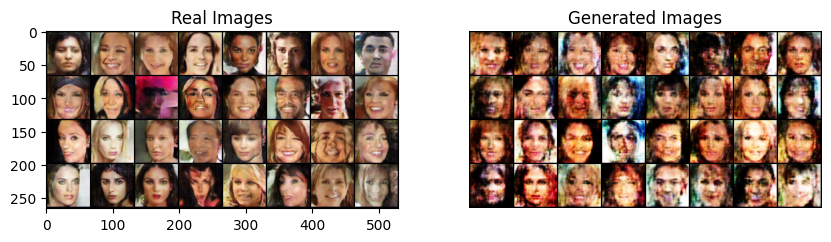

In [17]:
gen_2 = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G).to(DEVICE)
train_minimax_plus_reconstruction(gen_2,disc,train_loader,num_epochs=125,save_dir='../Submission/checkpoints', MSE_FACTOR=0.3)

#### From observations over performance of both models, I can say that the pure reconstruction loss model performs better than the Minimax + Reconstruction loss model.
 - Strange outcome, but the later gen2 could be improved by adding more residual blocks,  self-attention layers, tweaking hyperparameters, etc but as gen1 is already performing better, I didn't spend more time on it.

 - The pure reconstruction loss model is able to generate images that are very similar to the original images just on the basis of reconstruction loss.

 ---

 ### Constructing the Membership Classification Dataset

- We construct a labeled dataset for training the membership classifier where:
  - **Members (1):** Images $ I $ generated from the victim generator $ G_v $. 
  Nearly 1000 images are to be used.
  - **Non-members (0):** Random real-world images not used in training. For this I am choosing random images of classes like animals, cars, etc from `Tiny ImageNet200`. -->

- Generating a dataset of 250 images for each class from Tiny ImageNet200 
- Classes like Table, Hourglass, Rocket, Capsicum are chosen. (Tried finding classes with more similarity among themselves and dissimilar to the Celeba dataset, process is time consuming, so I stopped)

In [12]:
def prepare_tiny_imagenet_dataset(source_root, output_dir, classes, images_per_class=250):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in classes:
        source_dir = os.path.join(source_root, class_name, "images")
        all_images = [f for f in os.listdir(source_dir) 
                     if f.endswith(('.JPEG', '.jpeg', '.png'))]
        
        selected_images = random.sample(all_images, 
                                     min(images_per_class, len(all_images)))
        for image in selected_images:
            shutil.copy(
                os.path.join(source_dir, image),
                os.path.join(output_dir, image)
            )
    print(f"Dataset preparation completed. Images saved to {output_dir}")
    return output_dir

source_root = "/home/vdnt/Documents/Adverserail_ML/Assignments/Assignment5/Submission/tiny-imagenet-200/train"
tiny_imagenet_classes = [
    'n03201208',  # Table
    'n03544143',  # Hourglass
    'n04008634',  # Rocket
    'n07720875',  # Capsicum
]

## DO NOT RUN THIS CELL AGAIN, IT WILL OVERWRITE THE EXISTING DATASET

# Membership_classifier_dataset = prepare_tiny_imagenet_dataset(
#     source_root=source_root,
#     output_dir="Membership_classifier_dataset/0",
#     classes=tiny_imagenet_classes,
#     images_per_class=250
# )

- Now, copying the images generated by victim generator to the Membership classifier dataset

In [13]:
def copy_images(dir1, dir2):
    os.makedirs(dir1, exist_ok=True) 
    for file in os.listdir(dir2):
        if file.endswith(('.jpg', '.png', '.jpeg')):  
            shutil.copy(os.path.join(dir2, file), os.path.join(dir1, file))

    print(f"All images from {dir2} copied to {dir1}.")

victim_gen_img_path = "../Submission/NEW_QUery_generated_dataset/images"
Membership_classifier_gen_img_dir = "Membership_classifier_dataset/1"
# copy_images(Membership_classifier_gen_img_dir, victim_gen_img_path)

In [14]:
for i in range(2):
    dir_path = f"Membership_classifier_dataset/{i}"
    num_files = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
    print(f"Number of files in {dir_path}:", num_files)

Number of files in Membership_classifier_dataset/0: 1000
Number of files in Membership_classifier_dataset/1: 1200


Current structure:
0 for non-members, 1 for members
```text
├── Membership_classifier_dataset
│   ├── 0
│   └── 1
```

In [15]:
Membership_classifier_dataset = '/home/vdnt/Documents/Adverserail_ML/Assignments/Assignment5/Submission/Membership_classifier_dataset'
mem_classifier_ds = ImageFolder(root=Membership_classifier_dataset, transform=transforms.ToTensor())
mem_classifier_loader = DataLoader(mem_classifier_ds, batch_size=BATCH_SIZE, shuffle=True)

Image shape: torch.Size([3, 64, 64])


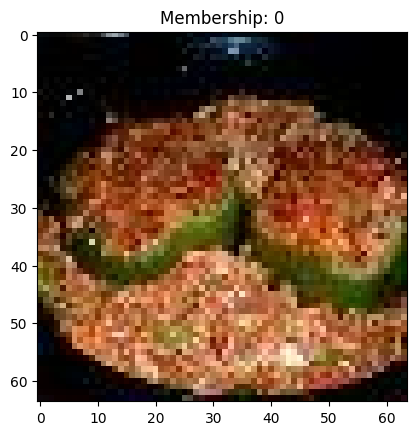

In [19]:
x, y = mem_classifier_ds.__getitem__(index=random.randint(0, len(mem_classifier_ds)))
print(f"Image shape: {x.shape}")
plt.imshow(x.squeeze(0).cpu().numpy().transpose(1, 2, 0))
plt.title(f"Membership: {y}")
plt.show()

### Training the Membership Classifier


In [20]:
class MembershipClassifier(nn.Module):
    def __init__(self, in_channels=3, fmap=128, num_classes=2):
        super().__init__()
        self.conv = nn.Sequential(
            # 3x64x64
            nn.Conv2d(in_channels, fmap, 3, 2, 1), #
            # 128x32x32
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(fmap),
            nn.Conv2d(fmap, fmap*2, 3, 2, 1), 
            # 256x16x16
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(fmap*2),
            nn.Conv2d(fmap*2, fmap*4, 3, 2, 1),
            # 512x8x8
            nn.LeakyReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(fmap*4*8*8, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            # nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)  
        x = self.classifier(x)
        return x


In [21]:
Membership_classifier = MembershipClassifier(in_channels=3, fmap=128, num_classes=2).to(DEVICE)
summary(Membership_classifier, (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
MembershipClassifier                     [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          3,584
│    └─LeakyReLU: 2-2                    [1, 128, 32, 32]          --
│    └─BatchNorm2d: 2-3                  [1, 128, 32, 32]          256
│    └─Conv2d: 2-4                       [1, 256, 16, 16]          295,168
│    └─LeakyReLU: 2-5                    [1, 256, 16, 16]          --
│    └─BatchNorm2d: 2-6                  [1, 256, 16, 16]          512
│    └─Conv2d: 2-7                       [1, 512, 8, 8]            1,180,160
│    └─LeakyReLU: 2-8                    [1, 512, 8, 8]            --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Linear: 2-9                       [1, 256]                  8,388,864
│    └─ReLU: 2-10                        [1, 256]            

In [22]:
mem_class_opt = optim.Adam(Membership_classifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

NUM_EPOCHS_MEM_CLASS = 5
loop = tqdm(range(NUM_EPOCHS_MEM_CLASS), desc='Surrogate M Training', colour='cyan')
Membership_classifier.train()
for epoch in loop:
    epoch_loss = 0
    correct = 0
    total = 0

    for id, (x,y) in enumerate(mem_classifier_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = Membership_classifier(x)
        loss = criterion(y_pred, y)

        mem_class_opt.zero_grad()
        loss.backward()
        mem_class_opt.step()

        epoch_loss+= loss.item()
        current_loss=epoch_loss / (id + 1)
        
        predictions=torch.argmax(y_pred, 1)
        correct +=(predictions == y).sum().item()
        total+= y.size(0)
        
        accuracy =(correct/total)*100
        
    tqdm.write(f'Epoch [{epoch+1}/{NUM_EPOCHS_MEM_CLASS}] || Accuracy: {accuracy:.2f}% ||  Loss: {current_loss:.4f}')


Surrogate M Training:  20%|██        | 1/5 [00:01<00:07,  1.90s/it]

Epoch [1/5] || Accuracy: 95.18% ||  Loss: 0.1343


Surrogate M Training:  40%|████      | 2/5 [00:03<00:04,  1.56s/it]

Epoch [2/5] || Accuracy: 99.36% ||  Loss: 0.0226


Surrogate M Training:  60%|██████    | 3/5 [00:04<00:02,  1.45s/it]

Epoch [3/5] || Accuracy: 99.77% ||  Loss: 0.0110


Surrogate M Training:  80%|████████  | 4/5 [00:05<00:01,  1.41s/it]

Epoch [4/5] || Accuracy: 99.77% ||  Loss: 0.0068


Surrogate M Training: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]

Epoch [5/5] || Accuracy: 99.95% ||  Loss: 0.0049


- Testing the Membership Classifier

In [23]:
MCD_test_dataset = prepare_tiny_imagenet_dataset(
    source_root=source_root,
    output_dir="MCD_test_dataset/0",
    classes=tiny_imagenet_classes,
    images_per_class=25
)

victim_gen_img_path = "../Submission/NEW_QUery_generated_dataset/images"
Membership_classifier_gen_img_dir_test = "MCD_test_dataset/1"
# copy_images(Membership_classifier_gen_img_dir_test, victim_gen_img_path)

MCD_test_dataset = '/home/vdnt/Documents/Adverserail_ML/Assignments/Assignment5/Submission/MCD_test_dataset'
mem_classifier_ds_test = ImageFolder(root=MCD_test_dataset, transform=transforms.ToTensor())
mem_classifier_loader_test = DataLoader(mem_classifier_ds_test, batch_size=BATCH_SIZE//2, shuffle=True)

Dataset preparation completed. Images saved to MCD_test_dataset/0


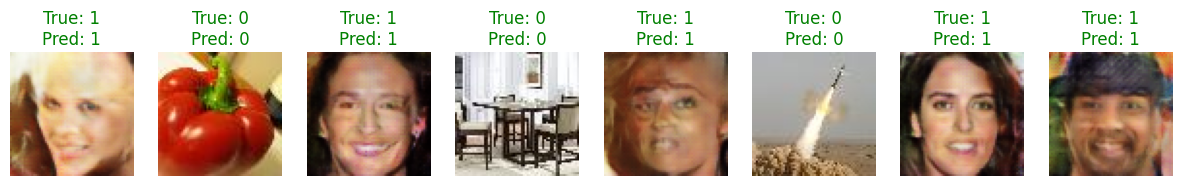

In [24]:
def test_membership_classifier(model, dataloader, num_images=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0) 
        axes[i].imshow(img)
        axes[i].axis('off')
        true_label = labels[i].item()
        pred_label = predictions[i].item()
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='green' if true_label == pred_label else 'red')
    
    plt.show()
    model.train()

test_membership_classifier(Membership_classifier, mem_classifier_loader_test)


### Optimizing Z to generalize MIA across the victim genererated images.

Since we have successfully trained the membership inference classifier, the next major step is optimizing the noise $Z$ so that the attack generalizes to the original victim generator $G_v$.

The surrogate generator $ G_r$ was trained on (image, noise) pairs obtained from the victim generator $ G_v$. However, due to differences between $G_r$ and $ G_v$, directly using the membership classifier on $ G_v$'s outputs may not be highly effective.

-  The key idea is to optimize $ Z$ so that the attack works across both $ G_r$ and $ G_v$.


- The goal is to find $ Z$ such that the membership inference classifier performs well when using samples from $ G_v$.

---

### Approach 1:
  **Gradient-based Optimization:** If we assume we can compute loss w.r.t $ Z$, update it iteratively.


   - Minimize:
     $$
     \mathcal{L} = \text{CrossEntropy}(\mathcal{R}(G_r(Z)), \mathcal{R}(G_v(Z)))
     $$

---

Since, we already extracted $Z$ and $G_v(Z)$ from the victim generator,
we need to compute $G_r(Z)$ and then compute gradient updates for $Z$ to minimize the loss.
<!-- 
<figure>
    <img src="Wf2.png" alt="Approach 1 to optimize Z">
    <figcaption>Approach 1 to optimize Z</figcaption>
</figure> -->

In [39]:
Ref_Gen_ckpt_path = "RCL_v1_checkpoint_epoch_119.pth"
Ref_Gen_ckpt = torch.load(Ref_Gen_ckpt_path, map_location=DEVICE)
Ref_Gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G).to(DEVICE)
Ref_Gen.load_state_dict(Ref_Gen_ckpt['gen_state_dict'])
Ref_Gen.eval()

summary(Ref_Gen, (1, Z_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Sequential: 2-1                   [1, 1024, 4, 4]           --
│    │    └─ConvTranspose2d: 3-1         [1, 1024, 4, 4]           1,638,400
│    │    └─BatchNorm2d: 3-2             [1, 1024, 4, 4]           2,048
│    │    └─LeakyReLU: 3-3               [1, 1024, 4, 4]           --
│    └─Sequential: 2-2                   [1, 512, 8, 8]            --
│    │    └─ConvTranspose2d: 3-4         [1, 512, 8, 8]            8,388,608
│    │    └─BatchNorm2d: 3-5             [1, 512, 8, 8]            1,024
│    │    └─LeakyReLU: 3-6               [1, 512, 8, 8]            --
│    └─SelfAttention: 2-3                [1, 512, 8, 8]            1
│    │    └─Conv2d: 3-7                  [1, 64, 8, 8]             32,832
│    │    └─Conv2d: 3-8                  [1, 64, 8, 8]        

In [40]:
Z_path = "../Submission/NEW_QUery_generated_dataset/noise_vectors"
Gv_Z_path = "../Submission/NEW_QUery_generated_dataset/images"

Gr_Z_path = "../Submission/NEW_QUery_generated_dataset/reference_generator_images"
os.makedirs(Gr_Z_path, exist_ok=True)

noise_files = sorted([f for f in os.listdir(Z_path) if f.endswith('.npy')])
to_pil = transforms.ToPILImage()

for noise_file in noise_files:
    noise_filepath = os.path.join(Z_path, noise_file)
    
    noise = np.load(noise_filepath)
    noise = torch.tensor(noise, dtype=torch.float32).view(Z_DIM, 1, 1)
    noise = noise.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        generated_image = Ref_Gen(noise)
        # print(generated_image.shape)
        generated_image = generated_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        # print(f"Generated image shape: {generated_image.shape}")
    image_pil = to_pil(generated_image)

    save_path = os.path.join(Gr_Z_path, f'Ref_gen_img_{noise_file.replace(".npy", ".png")}')
    image_pil.save(save_path)

print("All images generated and saved successfully!")


All images generated and saved successfully!


In [31]:
GEN_DIR = "/home/vdnt/Documents/Adverserail_ML/Assignments/Assignment5/Submission/NEW_QUery_generated_dataset"
for dir in os.listdir(GEN_DIR):
    if os.path.isdir(os.path.join(GEN_DIR, dir)):
        print(f"Length of {dir}: {len(os.listdir(os.path.join(GEN_DIR, dir)))}")


Length of noise_vectors: 1200
Length of images: 1200
Length of reference_generator_images: 1200


In [32]:
class OPT_Z_Dataset(Dataset):
    def __init__(self, root_dir, image_transform=None):
        self.root_dir = root_dir
        self.image_transform = image_transform or transforms.ToTensor()
        
        self.image_dir = os.path.join(root_dir, 'images')
        self.noise_dir = os.path.join(root_dir, 'noise_vectors')
        self.reference_dir = os.path.join(root_dir, 'reference_generator_images')
        
        self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                  if f.endswith('.png')])
        self.noise_files = sorted([f for f in os.listdir(self.noise_dir) 
                                  if f.endswith('.npy')])
        self.reference_files = sorted([f for f in os.listdir(self.reference_dir) 
                                      if f.endswith('.png')])
        
    def __len__(self):
        assert len(self.noise_files) == len(self.image_files) == len(self.reference_files)
        return len(self.noise_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        file_id = idx
        
        img_filename = self.image_files[file_id]
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        if self.image_transform:
            image = self.image_transform(image)
            
        noise_filename = self.noise_files[file_id]
        noise_path = os.path.join(self.noise_dir, noise_filename)
        noise_vector = torch.from_numpy(np.load(noise_path)).float()
        
        ref_filename = self.reference_files[file_id]
        ref_path = os.path.join(self.reference_dir, ref_filename)
        ref_image = Image.open(ref_path).convert('RGB')
        if self.image_transform:
            ref_image = self.image_transform(ref_image)
            
        sample = {
            'image': image,
            'noise_vector': noise_vector,
            'reference_image': ref_image,
        }
        
        return sample

In [33]:
Z_path = "../Submission/NEW_QUery_generated_dataset/noise_vectors"
Gv_Z_path = "../Submission/NEW_QUery_generated_dataset/images"
Gr_Z_path = "../Submission/NEW_QUery_generated_dataset/reference_generator_images"

optim_Z_train_ds = OPT_Z_Dataset(root_dir=GEN_DIR, image_transform=transforms.ToTensor())
optim_Z_train_loader = DataLoader(optim_Z_train_ds, batch_size=BATCH_SIZE, shuffle=True)

sample = optim_Z_train_ds.__getitem__(idx=random.randint(0, len(optim_Z_train_ds)))
print(f'noise_vector: {sample["noise_vector"].shape}')
print(f'image: {sample["image"].shape}')
print(f'reference_image: {sample["reference_image"].shape}')

noise_vector: torch.Size([1, 100])
image: torch.Size([3, 64, 64])
reference_image: torch.Size([3, 64, 64])


In [34]:
def optimize_z_for_mia_A1(optim_Z_train_loader, membership_classifier, num_epochs=50, learning_rate=3e-4):
    membership_classifier.eval()
    membership_classifier.to(DEVICE)

    for batch_idx, batch in enumerate(optim_Z_train_loader):
        image = batch['image'].to(DEVICE)
        reference_image = batch['reference_image'].to(DEVICE)
        # We clone the noise vector to avoid modifying the original data
        noise_vector = batch['noise_vector'].to(DEVICE).clone().detach() 
        
        noise_vector = torch.nn.Parameter(noise_vector, requires_grad=True)  

        optimizer = optim.Adam([noise_vector], lr=learning_rate)

        loop = tqdm(range(num_epochs), desc='Optimizing Z for MIA Approach1', colour='yellow')
        for epoch in loop:
            optimizer.zero_grad()

            Gv_pred = membership_classifier(image)
            Gr_pred = membership_classifier(reference_image)

            loss = F.smooth_l1_loss(Gv_pred, Gr_pred)

            loss.backward()
            optimizer.step()

            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] || Loss: {loss.item()}")

        print("Optimization of Z completed!")
        print(f"Optimized noise vector shape: {noise_vector.shape}")

    return noise_vector


In [91]:
optimized_noise_vector = optimize_z_for_mia_A1(optim_Z_train_loader, Membership_classifier, num_epochs=50, learning_rate=3e-4)

print(f"Optimized noise vector shape: {optimized_noise_vector.shape}")

Optimizing Z for MIA:  16%|█▌        | 8/50 [00:00<00:00, 75.81it/s]

Epoch [0/50] || Loss: 15.341754913330078


Optimizing Z for MIA:  32%|███▏      | 16/50 [00:00<00:01, 27.70it/s]

Epoch [10/50] || Loss: 15.341754913330078


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 28.03it/s]

Epoch [20/50] || Loss: 15.341754913330078


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.90it/s]

Epoch [30/50] || Loss: 15.341754913330078


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.69it/s]

Epoch [40/50] || Loss: 15.341754913330078
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.97it/s]

Epoch [0/50] || Loss: 15.406144142150879


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.25it/s]

Epoch [10/50] || Loss: 15.406144142150879


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.29it/s]

Epoch [20/50] || Loss: 15.406144142150879


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.22it/s]

Epoch [30/50] || Loss: 15.406144142150879


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.61it/s]

Epoch [40/50] || Loss: 15.406144142150879
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.37it/s]

Epoch [0/50] || Loss: 14.890523910522461


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.16it/s]

Epoch [10/50] || Loss: 14.890523910522461


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.29it/s]

Epoch [20/50] || Loss: 14.890523910522461


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.21it/s]

Epoch [30/50] || Loss: 14.890523910522461


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.60it/s]

Epoch [40/50] || Loss: 14.890523910522461
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.35it/s]

Epoch [0/50] || Loss: 16.123275756835938


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.20it/s]

Epoch [10/50] || Loss: 16.123275756835938


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.19it/s]

Epoch [20/50] || Loss: 16.123275756835938


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.16it/s]

Epoch [30/50] || Loss: 16.123275756835938


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.52it/s]

Epoch [40/50] || Loss: 16.123275756835938
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.41it/s]

Epoch [0/50] || Loss: 15.530759811401367


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.16it/s]

Epoch [10/50] || Loss: 15.530759811401367


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.13it/s]

Epoch [20/50] || Loss: 15.530759811401367


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.10it/s]

Epoch [30/50] || Loss: 15.530759811401367


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.49it/s]

Epoch [40/50] || Loss: 15.530759811401367
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.38it/s]

Epoch [0/50] || Loss: 16.507057189941406


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.08it/s]

Epoch [10/50] || Loss: 16.507057189941406


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.14it/s]

Epoch [20/50] || Loss: 16.507057189941406


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.08it/s]

Epoch [30/50] || Loss: 16.507057189941406


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.45it/s]

Epoch [40/50] || Loss: 16.507057189941406
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 67.99it/s]

Epoch [0/50] || Loss: 15.371875762939453


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.07it/s]

Epoch [10/50] || Loss: 15.371875762939453


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.16it/s]

Epoch [20/50] || Loss: 15.371875762939453


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.13it/s]

Epoch [30/50] || Loss: 15.371875762939453


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.42it/s]

Epoch [40/50] || Loss: 15.371875762939453
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.26it/s]

Epoch [0/50] || Loss: 15.552804946899414


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.08it/s]

Epoch [10/50] || Loss: 15.552804946899414


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.10it/s]

Epoch [20/50] || Loss: 15.552804946899414


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.09it/s]

Epoch [30/50] || Loss: 15.552804946899414


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.44it/s]

Epoch [40/50] || Loss: 15.552804946899414
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.07it/s]

Epoch [0/50] || Loss: 15.95701789855957


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.32it/s]

Epoch [10/50] || Loss: 15.95701789855957


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.21it/s]

Epoch [20/50] || Loss: 15.95701789855957


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.13it/s]

Epoch [30/50] || Loss: 15.95701789855957


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.46it/s]

Epoch [40/50] || Loss: 15.95701789855957
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.39it/s]

Epoch [0/50] || Loss: 15.216121673583984


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.01it/s]

Epoch [10/50] || Loss: 15.216121673583984


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.12it/s]

Epoch [20/50] || Loss: 15.216121673583984


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.07it/s]

Epoch [30/50] || Loss: 15.216121673583984


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.45it/s]

Epoch [40/50] || Loss: 15.216121673583984
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.24it/s]

Epoch [0/50] || Loss: 16.294334411621094


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 29.11it/s]

Epoch [10/50] || Loss: 16.294334411621094


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.03it/s]

Epoch [20/50] || Loss: 16.294334411621094


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.03it/s]

Epoch [30/50] || Loss: 16.294334411621094


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.41it/s]

Epoch [40/50] || Loss: 16.294334411621094
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.02it/s]

Epoch [0/50] || Loss: 15.967185974121094


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.90it/s]

Epoch [10/50] || Loss: 15.967185974121094


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.01it/s]

Epoch [20/50] || Loss: 15.967185974121094


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 25.00it/s]

Epoch [30/50] || Loss: 15.967185974121094


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.37it/s]

Epoch [40/50] || Loss: 15.967185974121094
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.21it/s]

Epoch [0/50] || Loss: 15.24471664428711


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.91it/s]

Epoch [10/50] || Loss: 15.24471664428711


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.02it/s]

Epoch [20/50] || Loss: 15.24471664428711


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 24.95it/s]

Epoch [30/50] || Loss: 15.24471664428711


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.36it/s]

Epoch [40/50] || Loss: 15.24471664428711
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.19it/s]

Epoch [0/50] || Loss: 15.462307929992676


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.96it/s]

Epoch [10/50] || Loss: 15.462307929992676


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 25.96it/s]

Epoch [20/50] || Loss: 15.462307929992676


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 24.95it/s]

Epoch [30/50] || Loss: 15.462307929992676


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.35it/s]

Epoch [40/50] || Loss: 15.462307929992676
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 67.62it/s]

Epoch [0/50] || Loss: 15.999372482299805


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.92it/s]

Epoch [10/50] || Loss: 15.999372482299805


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.01it/s]

Epoch [20/50] || Loss: 15.999372482299805


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 24.99it/s]

Epoch [30/50] || Loss: 15.999372482299805


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.31it/s]

Epoch [40/50] || Loss: 15.999372482299805
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 67.85it/s]

Epoch [0/50] || Loss: 16.163707733154297


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.93it/s]

Epoch [10/50] || Loss: 16.163707733154297


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 26.02it/s]

Epoch [20/50] || Loss: 16.163707733154297


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 24.95it/s]

Epoch [30/50] || Loss: 16.163707733154297


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.32it/s]

Epoch [40/50] || Loss: 16.163707733154297
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 67.69it/s]

Epoch [0/50] || Loss: 16.313812255859375


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.88it/s]

Epoch [10/50] || Loss: 16.313812255859375


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 25.95it/s]

Epoch [20/50] || Loss: 16.313812255859375


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 24.97it/s]

Epoch [30/50] || Loss: 16.313812255859375


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.27it/s]

Epoch [40/50] || Loss: 16.313812255859375
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 68.11it/s]

Epoch [0/50] || Loss: 16.637319564819336


Optimizing Z for MIA:  40%|████      | 20/50 [00:00<00:01, 28.85it/s]

Epoch [10/50] || Loss: 16.637319564819336


Optimizing Z for MIA:  60%|██████    | 30/50 [00:01<00:00, 25.95it/s]

Epoch [20/50] || Loss: 16.637319564819336


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 24.91it/s]

Epoch [30/50] || Loss: 16.637319564819336


Optimizing Z for MIA: 100%|██████████| 50/50 [00:02<00:00, 24.31it/s]

Epoch [40/50] || Loss: 16.637319564819336
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA:  18%|█▊        | 9/50 [00:00<00:00, 85.97it/s]

Epoch [0/50] || Loss: 15.43989372253418


Optimizing Z for MIA:  36%|███▌      | 18/50 [00:00<00:00, 38.72it/s]

Epoch [10/50] || Loss: 15.43989372253418


Optimizing Z for MIA:  48%|████▊     | 24/50 [00:00<00:00, 27.29it/s]

Epoch [20/50] || Loss: 15.43989372253418


Optimizing Z for MIA:  80%|████████  | 40/50 [00:01<00:00, 34.02it/s]

Epoch [30/50] || Loss: 15.43989372253418


Optimizing Z for MIA: 100%|██████████| 50/50 [00:01<00:00, 31.74it/s]

Epoch [40/50] || Loss: 15.43989372253418
Optimization of Z completed!
Optimized noise vector shape: torch.Size([48, 1, 100])
Optimized noise vector shape: torch.Size([48, 1, 100])


Approach 1 did not work as expected. The independent gradient update for $Z$ did not yield good results. The loss did not converge over the epochs.

---

### Approach 2:

The Second approach is quite similar ot the first one. Here instead of the treating reference generator $G_r$ as a ground truth, we would straight away use the exploit the fact that the membership classifier is trained on the reference generator $G_r$ which is ultimately trained on the original victim generator $G_v$.

SO we would directly use ones as ground truth and zeros as non-membership ground truth.
<!--  THe question is not understood -->

In [41]:
def optimize_z_for_mia_A2(optim_Z_train_loader, membership_classifier, num_epochs=50, learning_rate=3e-4):
    membership_classifier.eval()
    membership_classifier.to(DEVICE)
    
    for batch_idx, batch in enumerate(optim_Z_train_loader):
        image = batch['image'].to(DEVICE)

        noise_vector = batch['noise_vector'].to(DEVICE).clone().detach()
        noise_vector = torch.nn.Parameter(noise_vector, requires_grad=True)  
        
        labels = torch.zeros((noise_vector.shape[0], 2), device=DEVICE)
        labels[:, 1] = 1.0 

        optimizer = optim.Adam([noise_vector], lr=learning_rate)
        loop = tqdm(range(num_epochs), desc='Optimizing Z for MIA Approach2', colour='yellow')
        
        for epoch in loop:
            optimizer.zero_grad()
            
            Gv_pred = membership_classifier(image)
            Gv_pred = F.softmax(Gv_pred, dim=1)  
            
            loss = F.binary_cross_entropy(Gv_pred, labels)
            
            loss.backward()
            optimizer.step()
            
            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] || Loss: {loss.item()}")
                
        print("Optimization of Z completed!")
        print(f"Optimized noise vector shape: {noise_vector.shape}")
        
    return noise_vector

In [42]:
optimized_noise_vector_A2 = optimize_z_for_mia_A2(optim_Z_train_loader, Membership_classifier, num_epochs=50, learning_rate=3e-4)

Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 7.988895231392235e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 40.94it/s]

Epoch [10/50] || Loss: 7.988895231392235e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 42.64it/s]

Epoch [20/50] || Loss: 7.988895231392235e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.29it/s]

Epoch [30/50] || Loss: 7.988895231392235e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 50.77it/s]

Epoch [40/50] || Loss: 7.988895231392235e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 8.789056300884113e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.92it/s]

Epoch [10/50] || Loss: 8.789056300884113e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.89it/s]

Epoch [20/50] || Loss: 8.789056300884113e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.64it/s]

Epoch [30/50] || Loss: 8.789056300884113e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.64it/s]

Epoch [40/50] || Loss: 8.789056300884113e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.00010873186693061143


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.95it/s]

Epoch [10/50] || Loss: 0.00010873186693061143


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.72it/s]

Epoch [20/50] || Loss: 0.00010873186693061143


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.40it/s]

Epoch [30/50] || Loss: 0.00010873186693061143


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.51it/s]

Epoch [40/50] || Loss: 0.00010873186693061143
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 4.113089380552992e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.79it/s]

Epoch [10/50] || Loss: 4.113089380552992e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.41it/s]

Epoch [20/50] || Loss: 4.113089380552992e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.25it/s]

Epoch [30/50] || Loss: 4.113089380552992e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.19it/s]

Epoch [40/50] || Loss: 4.113089380552992e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 3.19865757774096e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.47it/s]

Epoch [10/50] || Loss: 3.19865757774096e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.23it/s]

Epoch [20/50] || Loss: 3.19865757774096e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.29it/s]

Epoch [30/50] || Loss: 3.19865757774096e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.55it/s]

Epoch [40/50] || Loss: 3.19865757774096e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 2.545399183873087e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.29it/s]

Epoch [10/50] || Loss: 2.545399183873087e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.34it/s]

Epoch [20/50] || Loss: 2.545399183873087e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.38it/s]

Epoch [30/50] || Loss: 2.545399183873087e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.39it/s]

Epoch [40/50] || Loss: 2.545399183873087e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 7.423200440825894e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.32it/s]

Epoch [10/50] || Loss: 7.423200440825894e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.29it/s]

Epoch [20/50] || Loss: 7.423200440825894e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.32it/s]

Epoch [30/50] || Loss: 7.423200440825894e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.70it/s]

Epoch [40/50] || Loss: 7.423200440825894e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 3.260221274103969e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.34it/s]

Epoch [10/50] || Loss: 3.260221274103969e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.26it/s]

Epoch [20/50] || Loss: 3.260221274103969e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.30it/s]

Epoch [30/50] || Loss: 3.260221274103969e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.23it/s]

Epoch [40/50] || Loss: 3.260221274103969e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.002476886846125126


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.40it/s]

Epoch [10/50] || Loss: 0.002476886846125126


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.28it/s]

Epoch [20/50] || Loss: 0.002476886846125126


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.30it/s]

Epoch [30/50] || Loss: 0.002476886846125126


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.01it/s]

Epoch [40/50] || Loss: 0.002476886846125126
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 2.3134094590204768e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.35it/s]

Epoch [10/50] || Loss: 2.3134094590204768e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.18it/s]

Epoch [20/50] || Loss: 2.3134094590204768e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.21it/s]

Epoch [30/50] || Loss: 2.3134094590204768e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.27it/s]

Epoch [40/50] || Loss: 2.3134094590204768e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.00278084515593946


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.27it/s]

Epoch [10/50] || Loss: 0.00278084515593946


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.25it/s]

Epoch [20/50] || Loss: 0.00278084515593946


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.21it/s]

Epoch [30/50] || Loss: 0.00278084515593946


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 50.87it/s]

Epoch [40/50] || Loss: 0.00278084515593946
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 2.9343715141294524e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.23it/s]

Epoch [10/50] || Loss: 2.9343715141294524e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.26it/s]

Epoch [20/50] || Loss: 2.9343715141294524e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.24it/s]

Epoch [30/50] || Loss: 2.9343715141294524e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.01it/s]

Epoch [40/50] || Loss: 2.9343715141294524e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 9.49424211285077e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.32it/s]

Epoch [10/50] || Loss: 9.49424211285077e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.26it/s]

Epoch [20/50] || Loss: 9.49424211285077e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.13it/s]

Epoch [30/50] || Loss: 9.49424211285077e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.29it/s]

Epoch [40/50] || Loss: 9.49424211285077e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.0010926412651315331


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.22it/s]

Epoch [10/50] || Loss: 0.0010926412651315331


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.14it/s]

Epoch [20/50] || Loss: 0.0010926412651315331


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.10it/s]

Epoch [30/50] || Loss: 0.0010926412651315331


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.39it/s]

Epoch [40/50] || Loss: 0.0010926412651315331
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 3.4406559279887006e-05


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.15it/s]

Epoch [10/50] || Loss: 3.4406559279887006e-05


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.13it/s]

Epoch [20/50] || Loss: 3.4406559279887006e-05


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.18it/s]

Epoch [30/50] || Loss: 3.4406559279887006e-05


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.29it/s]

Epoch [40/50] || Loss: 3.4406559279887006e-05
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.0024073603563010693


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.31it/s]

Epoch [10/50] || Loss: 0.0024073603563010693


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.19it/s]

Epoch [20/50] || Loss: 0.0024073603563010693


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.21it/s]

Epoch [30/50] || Loss: 0.0024073603563010693


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.44it/s]

Epoch [40/50] || Loss: 0.0024073603563010693
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.0002880572574213147


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.11it/s]

Epoch [10/50] || Loss: 0.0002880572574213147


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.07it/s]

Epoch [20/50] || Loss: 0.0002880572574213147


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 43.05it/s]

Epoch [30/50] || Loss: 0.0002880572574213147


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 50.88it/s]

Epoch [40/50] || Loss: 0.0002880572574213147
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] || Loss: 0.0009499609004706144


Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 43.06it/s]

Epoch [10/50] || Loss: 0.0009499609004706144


Optimizing Z for MIA Approach2:  42%|████▏     | 21/50 [00:00<00:00, 43.01it/s]

Epoch [20/50] || Loss: 0.0009499609004706144


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 42.96it/s]

Epoch [30/50] || Loss: 0.0009499609004706144


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 51.14it/s]

Epoch [40/50] || Loss: 0.0009499609004706144
Optimization of Z completed!
Optimized noise vector shape: torch.Size([64, 1, 100])



Optimizing Z for MIA Approach2:  22%|██▏       | 11/50 [00:00<00:00, 54.29it/s]

Epoch [0/50] || Loss: 0.00033034684020094573
Epoch [10/50] || Loss: 0.00033034684020094573


Optimizing Z for MIA Approach2:  62%|██████▏   | 31/50 [00:00<00:00, 55.78it/s]

Epoch [20/50] || Loss: 0.00033034684020094573
Epoch [30/50] || Loss: 0.00033034684020094573


Optimizing Z for MIA Approach2: 100%|██████████| 50/50 [00:00<00:00, 65.14it/s]

Epoch [40/50] || Loss: 0.00033034684020094573
Optimization of Z completed!
Optimized noise vector shape: torch.Size([48, 1, 100])


Clearly approach 2 worked better. The loss converged over the epochs and the noise vector was optimized for the membership classifier.
But the this approach seems unclear plus the question is not understood well, as we are not using the reference generator $G_r$ in this approach.

As per the question, we are asked to optmize Z , but there was multiple context of using $G_r$ and $G_v$, if we consider the MIA classifier too.

The flow of gradients required to update $Z$ must be passing through $G_r$, as directly optimizing $Z$ on victim generator $G_v$ misleads the MI attack.

---